# Samantha Williams - Part 3 Jupyter Notebook

You're a data scientist at Lyft Bay Wheels (https://www.lyft.com/bikes/bay-wheels), formerly known as Ford GoBike, the
  company running Bay Area Bikeshare. You are trying to increase ridership, and
  you want to offer deals through the mobile app to do so. 
  
What deals do you offer though? Currently, your company has several options which can change over time.  Please visit the website to see the current offers and other marketing information. Frequent offers include: 
  * Single Ride 
  * Monthly Membership
  * Annual Membership
  * Bike Share for All
  * Access Pass
  * Corporate Membership
  * etc.

Through this project, you will answer these questions: 

  * What are the 5 most popular trips that you would call "commuter trips"? 
  
  * What are your recommendations for offers (justify based on your findings)?

Please note that there are no exact answers to the above questions, just like in the proverbial real world.  This is not a simple exercise where each question above will have a simple SQL query. It is an exercise in analytics over inexact and dirty data. 

You won't find a column in a table labeled "commuter trip".  You will find you need to do quite a bit of data exploration using SQL queries to determine your own definition of a communter trip.  In data exploration process, you will find a lot of dirty data, that you will need to either clean or filter out. You will then write SQL queries to find the communter trips.

Likewise to make your recommendations, you will need to do data exploration, cleaning or filtering dirty data, etc. to come up with the final queries that will give you the supporting data for your recommendations. You can make any recommendations regarding the offers, including, but not limited to: 
  * market offers differently to generate more revenue 
  * remove offers that are not working 
  * modify exising offers to generate more revenue
  * create new offers for hidden business opportunities you have found
  * etc. 

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import numpy as np

%matplotlib inline

## Exploratory Analysis
So far we have looked at some initial data points located in the README.md file. In this section, we will dig further into the data, including using some techniques to visualize the data to identify the five most frequent commuter trips and make recommendations oh how to increase ridership, generate more revenue or hidden business opportunities.

### What is a commuter?

First, we must define a commuter trip. The bikeshare_trips dataset does identify customers into two categories under the column subscriber_type as either subscriber or customer. We know from part 1 and 2 of our exploration in the README.md file that during the morning (7-10 AM) rush hour 95% Subscribers and 5% customers make a trip and during evening (5-8 PM) rush hour, ridership is comprised of 10% customer and 90% subscribers. We also know that overall subscribers make up 86% of all ridership. Based on this information it would be safe to say that it is likely a commuter trip is identified as a subscriber.

In [72]:
client = bigquery.Client()

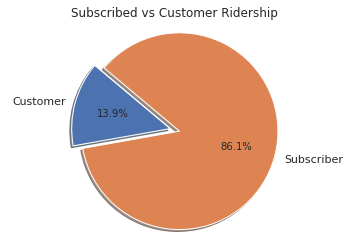

In [79]:
sql_q = """
SELECT count(trip_id) as count, subscriber_type
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY subscriber_type
"""
df = client.query(sql_q).to_dataframe()
labels = ['Customer', 'Subscriber']
sizes = df['count']
 
plt.pie(sizes, explode=explode, labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=140, )
plt.title('Subscribed vs Customer Ridership')
plt.axis('equal')
plt.show()

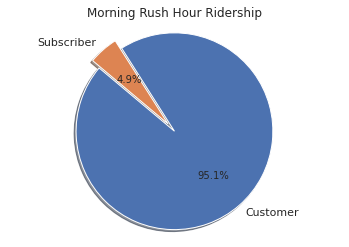

In [146]:
sql_m = """
SELECT count(trip_id) as m_trips, subscriber_type
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(HOUR FROM start_date) >= 7 AND EXTRACT(HOUR FROM start_date) < 10
GROUP BY 2
"""

dfm = client.query(sql_m).to_dataframe()
labels = ['Customer', 'Subscriber']
sizes = dfm['m_trips']
 
plt.pie(sizes, explode=explode, labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=140, )
plt.title('Morning Rush Hour Ridership')
plt.axis('equal')
plt.show()

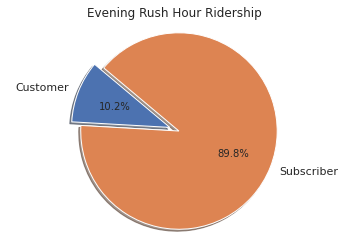

In [172]:
sql_e = """
SELECT count(trip_id) as e_trips, subscriber_type
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE EXTRACT(HOUR FROM start_date) >= 17 AND EXTRACT(HOUR FROM start_date) < 20
GROUP BY 2
"""

dfe = client.query(sql_e).to_dataframe()
labels = ['Customer', 'Subscriber']
sizes = dfe['e_trips']
 
plt.pie(sizes, explode=explode, labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=140, )
plt.title('Evening Rush Hour Ridership')
plt.axis('equal')
plt.show()

### When do commuters commute? 

I wondered if my earlier definitions of weekday morning and evening rush hour were accurate and how did that compare to weekend trips. As we can see from the graph weekday peak traffic times occur between 7-10 AM and 4-7 PM. Weekend bike usage was minimal during the weekday rush hour times, with a steady peak in usage occurring from 12-2 PM. Weekend usage is significantly less, leading to a stronger conclusion the subscribers are more likely commuters in the given datasets.

In [178]:
sql_wend = """
SELECT EXTRACT(HOUR FROM start_date) AS hour, COUNT(*) AS weekend_trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE CAST(FORMAT_DATE('%w', DATE(start_date)) AS int64) = 0 OR CAST(FORMAT_DATE('%w', DATE(start_date)) AS int64) = 6
GROUP BY hour
ORDER BY hour ASC
"""
sql_wday = """
SELECT EXTRACT(HOUR FROM start_date) AS hour, COUNT(*) AS weekday_trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE CAST(FORMAT_DATE('%w', DATE(start_date)) AS int64) > 0 OR CAST(FORMAT_DATE('%w', DATE(start_date)) AS int64) < 6
GROUP BY hour
ORDER BY hour ASC
"""

df_end = client.query(sql_wend).to_dataframe()
df_day = client.query(sql_wday).to_dataframe()

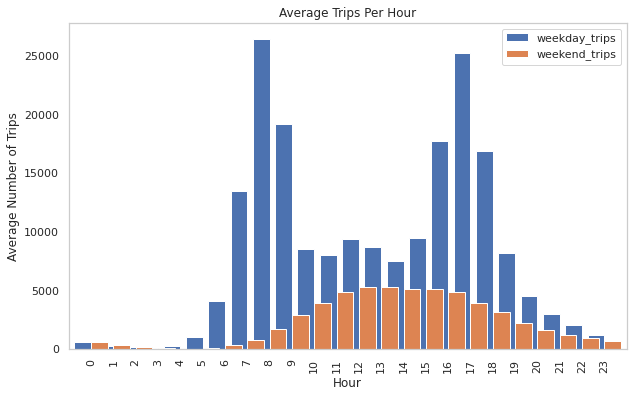

In [180]:
weekday_avg, weekend_avg = df_day.weekday_trips/5, df_end.weekend_trips/2
trips = pd.concat([weekday_avg, weekend_avg], axis=1)
trips.plot.bar(figsize=(10,6), title="Average Trips Per Hour", width=1.5, grid=False)
plt.xlabel('Hour')
plt.ylabel('Average Number of Trips')
plt.show()

### How does trip time differ among subscribers and customers? 

For the majority of both customers and subscribers, trip time tends to cut off around the 35-minute mark. We can see from our query there are instances where a trip has occurred for more than 24 hours but are rare compared to the majority of trips. Subscriber trips reach their max time limit the 20-minute mark with peak trips falling between 5 and 10 minutes. Customers stay fairly consistent with nearly all trips reaching a max time limit of 35 minutes.

In [245]:
sql_t = """
SELECT subscriber_type, trip_id, duration_sec
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE duration_sec >= 300 AND duration_sec <= 86400
ORDER by duration_sec
"""

df_t = client.query(sql_t).to_dataframe()
df_t['duration_sec'] = df_t.duration_sec/60
df_t

,subscriber_type,trip_id,duration_sec
0,Subscriber,189849,5.000000
1,Subscriber,600666,5.000000
2,Subscriber,704094,5.000000
3,Subscriber,883838,5.000000
4,Subscriber,1003920,5.000000
...,...,...,...
804655,Customer,924015,1437.133333
804656,Customer,1270563,1438.750000
804657,Customer,299961,1439.083333
804658,Customer,165883,1439.383333


Text(0, 0.5, 'Number of Trips')

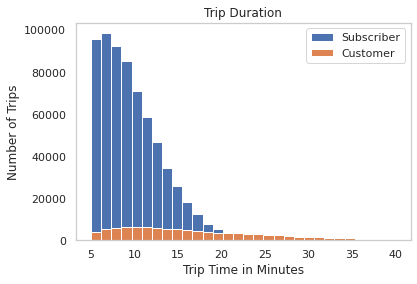

In [246]:
plt.hist(df_t[(df_t.duration_sec <= 40) & (df_t.subscriber_type == "Subscriber")]['duration_sec'], bins = 30,)
plt.hist(df_t[(df_t.duration_sec <= 40) & (df_t.subscriber_type == "Customer")]['duration_sec'], bins = 30)
plt.title("Trip Duration")
plt.legend(['Subscriber', 'Customer'])
plt.xlabel("Trip Time in Minutes")
plt.ylabel("Number of Trips")

### What are the 5 most popular trips that you could be considered commuter trips?

If we consider what the data has shown thus far, subscribers are in general commuters with the majority of trips by subscribers starting at one station and ending at another station. We could limit this to weekdays only and during peak rush hour, however as the gig economy has taken hold, this may not be the case for a small but growing population, it could also exclude students who commute to campus. As a result, we will look at all subscribers to identify the 5 most popular trips commuter trips. 

The top 4 start stations are the same 4 four end stations that subscribers are commuting to and from. The 5th most popular start and end station are the unique two stations among the top 5 start and end stations. 

In [199]:
sql_st = """
SELECT start_station_name, end_station_name, subscriber_type, count(*) as trip_freq
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE start_station_name <> end_station_name 
GROUP BY start_station_name, end_station_name, subscriber_type
HAVING count(*) >300
ORDER BY trip_freq DESC LIMIT 5
"""

df_stat = client.query(sql_st).to_dataframe()
df_stat

,start_station_name,end_station_name,subscriber_type,trip_freq
0,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,Subscriber,8305
1,2nd at Townsend,Harry Bridges Plaza (Ferry Building),Subscriber,6931
2,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),Subscriber,6641
3,Harry Bridges Plaza (Ferry Building),2nd at Townsend,Subscriber,6332
4,Embarcadero at Sansome,Steuart at Market,Subscriber,6200


### Do the places where customers should outnumber subscribers make sense?

For the most part, you can find customers where you would expect, stations near tourist attractions and they are likely to return the bike to the same station. The station at Yerba Buena is rather touristy and Washington and Kearney (or Kearny) are surrounded by hotels. However, there is an instance where subscribers (71) were outnumbered by customers (1113) at a station located in Palo A lot near Stanford University. This could be an outlier, as riders may be visiting the school for tours, games, or other events. However, it could also be that students are not aware that there is a subscriber program. 

In [202]:
sql_c = """
SELECT start_station_name, end_station_name, subscriber_type, count(*) as trip_freq
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE start_station_name = end_station_name
GROUP BY start_station_name, end_station_name, subscriber_type
ORDER BY start_station_name DESC LIMIT 10
"""

df_c = client.query(sql_c).to_dataframe()
df_c

,start_station_name,end_station_name,subscriber_type,trip_freq
0,Yerba Buena Center of the Arts (3rd @ Howard),Yerba Buena Center of the Arts (3rd @ Howard),Customer,349
1,Yerba Buena Center of the Arts (3rd @ Howard),Yerba Buena Center of the Arts (3rd @ Howard),Subscriber,97
2,Washington at Kearny,Washington at Kearny,Customer,274
3,Washington at Kearny,Washington at Kearny,Subscriber,40
4,Washington at Kearney,Washington at Kearney,Customer,83
5,Washington at Kearney,Washington at Kearney,Subscriber,6
6,University and Emerson,University and Emerson,Subscriber,71
7,University and Emerson,University and Emerson,Customer,1113
8,Townsend at 7th,Townsend at 7th,Subscriber,427
9,Townsend at 7th,Townsend at 7th,Customer,168


## Recommendations

- It is clear that the majority of subscribers can be identified as commuters. However, it does appear there may be instances where customers are regularly using GoBike to commute around local areas such as their college campus. It could be lucrative to offer not just a yearly subscription but a monthly option. Remember that ridership does decrease in the winter months (Part 2 of the README.md file). It could also be attractive to potential subscribers to offer a student discount for stations used within a 5-mile radius of campus to attract those customers who regularly use GoBike but want more flexibility. 

- Each bike sitting in a dock is lost revenue, there could be more opportunities to encourage customers to increase their ridership through weekend passes that allow unlimited 30-minute rides from 11 AM to 4 PM on weekends during nonpeak months, May June and July. Additionally, you could offer discounts for customer rides on weekdays between the hours of 11 AM and 1 PM.

- This dataset is not perfect with several rides occurring more than 1 day and less 5 minutes. This could be an error in understanding how GoBikes and docking stations work. It would be worth investigating these anomalies further to find out what information or user error could be avoided for a better experience with the product.